# [2.X코드반영] Lab 07-1 Application & Tips 학습률(Learning Rate)과 데이터 전처리(Data Preprocessing)

## Learning rate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.4.1


In [3]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

# Evaluation our model using this test dataset
x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]

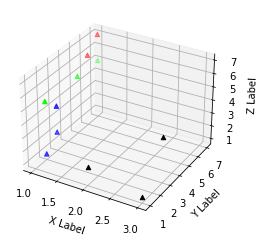

In [4]:
x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]
x3 = [x[2] for x in x_train]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,x3, c=y_train, marker='^')

ax.scatter(x_test[0][0],x_test[0][1],x_test[0][0], c='black', marker='^')
ax.scatter(x_test[1][0],x_test[1][1],x_test[1][1], c='black', marker='^')
ax.scatter(x_test[2][0],x_test[2][1],x_test[2][2], c='black', marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

Batch Size는 한번에 학습시킬 Size이다.

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))#.repeat()

In [6]:
W = tf.Variable(tf.random.normal((3, 3)))
b = tf.Variable(tf.random.normal((3,)))

In [23]:
def softmax_fn(features):
    hypothesis = tf.nn.softmax(tf.matmul(features, W) + b)
    return hypothesis

Cost 함수 : Cross Entrophy loss 사용

In [24]:
def loss_fn(hypothesis, features, labels):
    cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(hypothesis), axis=1))
    return cost

- starter_learning_rate : 최초 학습시 사용될 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
- global_step : 현재 학습 횟수
- 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
- 0.96 : 기존 learning에 곱할 값
- 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [25]:
is_decay = True
starter_learning_rate = 0.1

if (is_decay):
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                  decay_steps = 1000,
                                                                  decay_rate = 0.96,
                                                                  staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)

else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)
    
def grad(hypthesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(softmax_fn(features), features, labels)
    return tape.gradient(loss_value, [W,b])

In [31]:
def accuracy_fn(hypothesis, labels):
    pred = tf.argmax(hypothesis, 1)
    is_correct = tf.equal(pred, tf.argmax(labels, 1))
    acc = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    return acc

In [32]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels in iter(dataset):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads = grad(softmax_fn(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print('Iter: {}, Loss: {:.4f}'.format(step, loss_fn(softmax_fn(features), features, labels)))
            
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)
test_acc = accuracy_fn(softmax_fn(x_test), y_test)
print('Test accuracy: {:.4f}'.format(test_acc))

Iter: 0, Loss: 0.2740
Iter: 100, Loss: 0.2682
Iter: 200, Loss: 0.2627
Iter: 300, Loss: 0.2575
Iter: 400, Loss: 0.2525
Iter: 500, Loss: 0.2478
Iter: 600, Loss: 0.2432
Iter: 700, Loss: 0.2389
Iter: 800, Loss: 0.2347
Iter: 900, Loss: 0.2307
Iter: 1000, Loss: 0.2269
Test accuracy: 1.0000


## Data Preprocessing(Feature scaling)

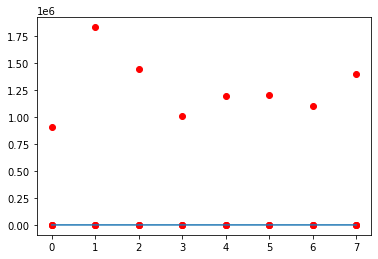

In [33]:

xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))


W = tf.Variable(tf.random.normal((4, 1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

선형회귀 모델

In [36]:
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

In [37]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(linearReg_fn(features),features,labels)
    return tape.gradient(loss_value, [W,b]), loss_value

In [38]:
EPOCHS = 101

for step in range(EPOCHS):
    for features, labels  in dataset:
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        hypo_value = linearReg_fn(features)
        grads, loss_value = grad(linearReg_fn(features), features, labels)        
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))    
    print("Iter: {}, Loss: {:.4f}, Prediction: {}".format(step, loss_value, hypo_value))

Iter: 0, Loss: nan, Prediction: [[-1032900.44]
 [-2078786.8 ]
 [-1635418.2 ]
 [-1146575.9 ]
 [-1351208.1 ]
 [-1362574.9 ]
 [-1248887.  ]
 [-1589935.6 ]]
Iter: 1, Loss: nan, Prediction: [[-1039453.8]
 [-2091979.4]
 [-1645796.4]
 [-1153851. ]
 [-1359782.1]
 [-1371221.1]
 [-1256811.5]
 [-1600025.1]]
Iter: 2, Loss: nan, Prediction: [[-1045965.8]
 [-2105088.8]
 [-1656109.1]
 [-1161080.1]
 [-1368302.1]
 [-1379812.8]
 [-1264686. ]
 [-1610050.9]]
Iter: 3, Loss: nan, Prediction: [[-1052437.4]
 [-2118116.5]
 [-1666357.6]
 [-1168264.2]
 [-1376769. ]
 [-1388350.9]
 [-1272511.6]
 [-1620014.4]]
Iter: 4, Loss: nan, Prediction: [[-1058869.1]
 [-2131064.2]
 [-1676543.1]
 [-1175404.2]
 [-1385184. ]
 [-1396836.6]
 [-1280289. ]
 [-1629916.6]]
Iter: 5, Loss: nan, Prediction: [[-1065261.8]
 [-2143933.2]
 [-1686666.8]
 [-1182500.9]
 [-1393547.6]
 [-1405270.8]
 [-1288019.1]
 [-1639758.5]]
Iter: 6, Loss: nan, Prediction: [[-1071616.1]
 [-2156725. ]
 [-1696729.6]
 [-1189554.9]
 [-1401861.2]
 [-1413654.2]
 [-129

Iter: 68, Loss: nan, Prediction: [[-1410517.9]
 [-2838969.8]
 [-2233426.8]
 [-1565776.5]
 [-1845258.6]
 [-1860783.6]
 [-1705512.6]
 [-2171310.8]]
Iter: 69, Loss: nan, Prediction: [[-1415316.8]
 [-2848630. ]
 [-2241026.2]
 [-1571103.8]
 [-1851537.1]
 [-1867114.9]
 [-1711315.5]
 [-2178698.8]]
Iter: 70, Loss: nan, Prediction: [[-1420099.1]
 [-2858257.8]
 [-2248600. ]
 [-1576412.9]
 [-1857794.1]
 [-1873424.6]
 [-1717098.5]
 [-2186061.8]]
Iter: 71, Loss: nan, Prediction: [[-1424865.6]
 [-2867853. ]
 [-2256148.2]
 [-1581704.1]
 [-1864030.2]
 [-1879713.1]
 [-1722862.2]
 [-2193400.2]]
Iter: 72, Loss: nan, Prediction: [[-1429616. ]
 [-2877416. ]
 [-2263671. ]
 [-1586977.6]
 [-1870245.4]
 [-1885980.6]
 [-1728606.6]
 [-2200714. ]]
Iter: 73, Loss: nan, Prediction: [[-1434350.6]
 [-2886947.2]
 [-2271169. ]
 [-1592233.8]
 [-1876439.8]
 [-1892227.1]
 [-1734331.8]
 [-2208003.5]]
Iter: 74, Loss: nan, Prediction: [[-1439069.6]
 [-2896447. ]
 [-2278642.2]
 [-1597472.4]
 [-1882613.9]
 [-1898453.4]
 [-1740